In [1]:
%matplotlib inline
from math import log
from numpy import clip, dstack
from skimage.color import rgb2gray
from skimage.io import imread, imsave, imshow
from skimage.util import img_as_ubyte, img_as_float


def downgrade(img, levels_n: int = 256):
    '''Уменьшение кол-ва уровней яркости изображения'''
    downgraded_img = img // (256 // levels_n)
    return downgraded_img


def restore(img, levels_n: int = 256):
    '''восстановление изображения для просмотра'''
    restored_img = img * (256 // levels_n)
    return restored_img


img_name = ('C:\cs173\lab1\eye.jpg')
img = imread(img_name)
img_gray = rgb2gray(img)
img_one_channel = img_as_ubyte(img_gray)
levels_n = 16
downgraded_img = downgrade(img_one_channel, levels_n)
restored_img = restore(downgraded_img, levels_n)
imsave(f'restored_img_{levels_n}_levels.png', restored_img)

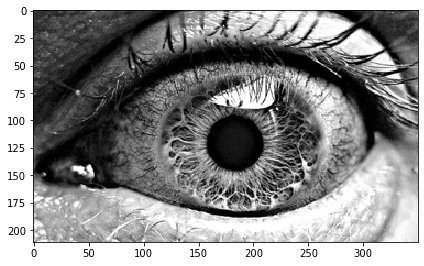

In [2]:
imshow(img_name)

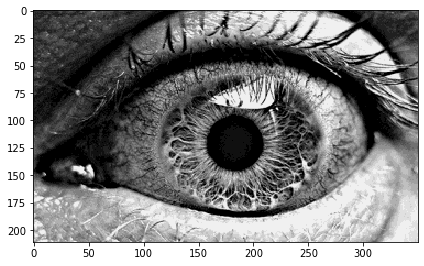

In [3]:
#  На 16 уровнях яркости изображение выглядит ещё приемлемо

output_img = imread('C:\cs173\lab1\\restored_img_16_levels.png')
imshow(output_img)

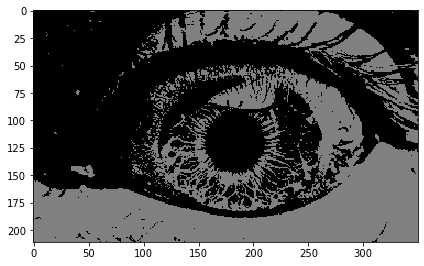

In [4]:
#  Так выглядит на 2 уровнях:

output_img = imread('C:\cs173\lab1\\restored_img_2_levels.png')
imshow(output_img)

In [5]:
def rgb_to_yuv(img):
    r = img[:, :, 0]
    g = img[:, :, 1]
    b = img[:, :, 2]
    y_channel = 0.299 * r + 0.587 * g + 0.114 * b

    '''Decimation for U and V '''
    u = []
    for x in range(img.shape[0]):
        if x % 2 != 0:
            u.append([])
        for y in range(img.shape[1]):
            if x % 2 != 0 and y % 2 != 0:
                average = img[x-1: x, y-1: y] / 4
                average_r = average[:, :, 0]
                average_g = average[:, :, 1]
                average_b = average[:, :, 2]
                u[x // 2].append(-0.147 * average_r - 0.289 * average_g +
                                 0.436 * average_b)

    v = []
    for x in range(img.shape[0]):
        if x % 2 != 0:
            v.append([])
        for y in range(img.shape[1]):
            if x % 2 != 0 and y % 2 != 0:
                average = img[x-1: x, y-1: y] / 4
                average_r = average[:, :, 0]
                average_g = average[:, :, 1]
                average_b = average[:, :, 2]
                v[x // 2].append(0.615 * average_r - 0.515 * average_g -
                                 0.100 * average_b)

    return (y_channel, u, v)


def yuv_to_rgb(yuv_img: tuple):
    y_channel = yuv_img[0]
    u = yuv_img[1]
    v = yuv_img[2]
    r = y_channel.copy()
    g = y_channel.copy()
    b = y_channel.copy()
    for x in range(y_channel.shape[0]):
        for y in range(y_channel.shape[1]):
            x_for_uv = x - 1 if x > len(u) // 2 else x
            y_for_uv = y - 1 if y > len(u[0]) // 2 else y
            u_channel = u[x_for_uv // 2][y_for_uv // 2]
            v_channel = v[x_for_uv // 2][y_for_uv // 2]
            r[x, y] = clip((y_channel[x, y] + 1.14 * v_channel), 0, 1)
            g[x, y] = clip((y_channel[x, y] - 0.395 * u_channel -
                           0.581 * v_channel), 0, 1)
            b[x, y] = clip((y_channel[x, y] + 2.032 * u_channel), 0, 1)

    rgb_img = dstack((r, g, b))
    return rgb_img


if __name__ == '__main__':
    img = imread('C:\cs173\\test_image.png')
    img_f = img_as_float(img)
    yuv_img = rgb_to_yuv(img_f)
    rgb_img = yuv_to_rgb(yuv_img)
    rgb_img = img_as_ubyte(rgb_img)

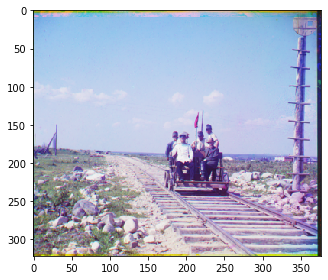

In [6]:
imshow(img)
# Исходное изображение

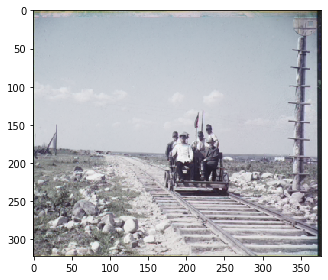

In [7]:
imshow(rgb_img)
#  После декодирования

In [8]:
def count_entropy(img, n_levels=None):
    if not n_levels:
        '''Считаем кол-во возможных вероятностей 
        !нужно посчитать вероятность для каждого уровня яркости'''
        p = set()
        try:
            for x in range(img.shape[0]):
                for y in range(img.shape[1]):
                    p.add(img[x, y][0])
                    p.add(img[x, y][1])
                    p.add(img[x, y][2])
        except IndexError:
            for x in range(img.shape[0]):
                for y in range(img.shape[1]):
                    p.add(img[x, y])
        prob = 1 / len(p)
    else:
        prob = 1 / n_levels

    V = img.shape[0] * img.shape[1]
    H = - (V * prob * log(prob, 2))
    return H


def count_standard_deviation(img1, img2):
    '''params:
    img1 - original image
    img2 - image after decoding '''

    deviation_sum = 0
    try:
        for x in range(img1.shape[0]):
            for y in range(img1.shape[1]):
                deviation_sum += (img1[x, y][0] + img1[x, y][1] +
                                  img1[x, y][2] - img2[x, y][0] -
                                  img2[x, y][1] - img2[x, y][2]) ** 2
    except IndexError:
        for x in range(img1.shape[0]):
            for y in range(img1.shape[1]):
                deviation_sum += (img1[x, y] - img2[x, y]) ** 2
    standard_deviation = deviation_sum / (img1.shape[0] * img1.shape[1])
    return standard_deviation


if __name__ == '__main__':
    img1 = imread('C:\cs173\lab1\eye.jpg')
    img1 = rgb2gray(img1)
    img1 = img_as_ubyte(img1)
    img2 = imread('C:\cs173\lab1\\restored_img_16_levels.png')
    print('Уменьшение уровней яркости:')
    print(count_entropy(img1, n_levels=256), count_entropy(img2))
    print(count_standard_deviation(img1, img2))

    img3 = imread('C:\cs173\\test_image.png')
    img3 = img_as_float(img3)
    img4 = imread('C:\cs173\\rgb_to_yuv.png')
    img4 = img_as_float(img4)
    print('Из RGB в YUV: ')
    print(count_entropy(img3), count_entropy(img4))
    print(count_standard_deviation(img3, img4))


Уменьшение уровней яркости:
2307.8125 18462.5
76.74442789438051
Из RGB в YUV: 
3893.514947189937 3958.9493377066683
0.006189366880370749
